## PCA direttamente su immagini
Verranno eseguiti dei test sulle immagini direttamente e verranno analizzate le distanze per identificare gli outliers

In [1]:
import cv2
import numpy as np
import glob
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import math
    
def divideImage(img,pcs):
    results = []
    lung = len(img) // pcs
    for i in range(pcs):
        results.append(img[(lung*i):(lung*(i+1)-1)][:])

    return results

In [2]:
def cutWorkSpace(img,border): 
    # dimensioni immagini
    img_h = 2048
    img_l = 2048
    # offset per posizionamento su area d'indagine
    offset_x = 600
    offset_y = 500
    
    #taglio per garantire la ricerca sull'area di interesse, evitando rumori dati dallo sfondo
    crop_img = img[offset_y:img_h-offset_y, offset_x:img_l-offset_x]
    
    # Convert the img to grayscale
    gray = cv2.cvtColor(crop_img,cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (9, 9), 0)
    high_thresh, thresh_im = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    #cv2.imwrite('provaT.jpg', thresh_im)
    lowThresh = 0.5*high_thresh
    
    
    # Apply edge detection method on the image
    #edges = cv2.Canny(blurred,20,150,apertureSize = 3)
    edges = cv2.Canny(blurred,20,150,apertureSize = 3)
    #cv2.imwrite('canny.jpg', edges)
    # This returns an array of r and theta values
    lines = cv2.HoughLines(edges,1,np.pi/180, 100)
    #cv2.imwrite('Risultati/resFS'+name+'c.jpg', edges)
    # The below for loop runs till r and theta values 
    # are in the range of the 2d array
    i = 0
    x_first = 0
    x_second = 0
    count = 0
    delta = 30
    thetaFinal = 0
    while count < 2:
        for r,theta in lines[i]:
            # Stores the value of cos(theta) in a
            a = np.cos(theta)

            # Stores the value of sin(theta) in b
            b = np.sin(theta)

            # x0 stores the value rcos(theta)
            x0 = a*r

            # y0 stores the value rsin(theta)
            y0 = b*r

            #ti define line lenght
            const = 3000
            # x1 stores the rounded off value of (rcos(theta)-1000sin(theta))
            x1 = int(x0 + const*(-b))

            # y1 stores the rounded off value of (rsin(theta)+1000cos(theta))
            y1 = int(y0 + const*(a))

            # x2 stores the rounded off value of (rcos(theta)+1000sin(theta))
            x2 = int(x0 - const*(-b))

            # y2 stores the rounded off value of (rsin(theta)-1000cos(theta))
            y2 = int(y0 - const*(a))

            if count == 0 :
                if theta != 0:
                    thetaFinal = 180-math.degrees(theta)
                x_first = x0
                #cv2.line(img,(x1+offset_x,y1+offset_y), (x2+offset_x,y2+offset_y), (0,0,255),2)
                count += 1
            else:
                if abs(x_first-x0) > delta :
                    x_second = x0
                    #cv2.line(img,(x1+offset_x,y1+offset_y), (x2+offset_x,y2+offset_y), (0,0,255),2)
                    count += 1
            i += 1
    # All the changes made in the input image are finally
    # written on a new image houghlines.jpg
    #cv2.imwrite('Risultati/res'+name+'.jpg', img)
    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # rotate our image by Theta degrees around the center of the image
    M = cv2.getRotationMatrix2D((cX, cY), -thetaFinal, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h))
    scale_percent = 30 # percent of original size

  
    if x_first < x_second:
        
        median = (x_second+x_first)//2
        temp = rotated[0:img_h-1, int(offset_x+median-border):int(offset_x+median+border)]
        width = int(temp.shape[1] * scale_percent / 100)
        height = int(temp.shape[0] * scale_percent / 100)
        dim = (width, height)
        temp = cv2.resize(temp, dim, interpolation = cv2.INTER_AREA)        
        gray = cv2.cvtColor(temp,cv2.COLOR_BGR2GRAY)
        return  gray
    else:
        median = (x_first+x_second)//2.
        temp = rotated[0:img_h-1, int(offset_x+median-border):int(offset_x+median+border)]        
        #blurred = cv2.GaussianBlur(temp, (3,3), 0)
        width = int(temp.shape[1] * scale_percent / 100)
        height = int(temp.shape[0] * scale_percent / 100)
        dim = (width, height)
        temp = cv2.resize(temp, dim, interpolation = cv2.INTER_AREA)
        gray = cv2.cvtColor(temp,cv2.COLOR_BGR2GRAY)
        return  gray
    

In [3]:
def dataCreation(imgs,results,num_features):
    if SIFT_method:
        sift = cv2.xfeatures2d.SIFT_create()  
    else: 
        orb = cv2.ORB_create()  
    data = []
    keypoints = []
    descriptors = []
    dico = []
    for i in range(len(imgs)):
        if SIFT_method:
            kp, descriptors_temp = sift.detectAndCompute(img, None)
        else:
            kp, descriptors_temp = orb.detectAndCompute(img, None)
            keypoints.append(kp)
        descriptors.append(descriptors_temp)
        for d in descriptors_temp:
            d = np.append(d,results[i])
            data.append(d)
           
    

    print(num_features)
    cols = []
    for i in range(num_features):
        cols.append('F'+str(i+1))
    
    cols.append('R')
        
    df = pd.DataFrame(data, columns = cols)
    
    return df,cols

In [4]:
def maxAndMedian(df,feature_cols):
    df = df.sort_values(by=['PC1'],ascending=False)
    
    features = feature_cols
    # Separating out the features
    x = df.loc[:, features].values
    
    maxT = 0
    totale = 0
    tot_element = [0]*len(feature_cols)
    for element in x:
        temp = np.linalg.norm(element)
        totale += temp
        tot_element += element
        if temp > maxT:
            maxT = temp
            
    media = totale / len(x)
    
    media_list = np.mean(x, axis=0)

    centerDist = np.linalg.norm(tot_element/len(x))
        
    return maxT, media,centerDist

In [5]:
def createDF(imgsWithClass):
    # creo histogramma con valori trovati di feature per ogni immagine di train
    train_imgs = imgsWithClass[0]
    res = []
    cols = []
    k = 0
    for img in train_imgs:
        im = []
        for d in img:
            for i in d:
                im.append(i)
        im.append(imgsWithClass[1][k])
        k += 1
        res.append(im)
    
    res = np.array(res)
    for i in range(len(res[0])-1):
        cols.append('F'+str(i+1))
        
    feature_cols = cols.copy()
    cols.append('R')

    df = pd.DataFrame(res ,columns = cols)
    
    return df, feature_cols

In [6]:
def create_PCA(df,cols,components):
    
    features = cols

    # Separating out the features
    x = df.loc[:, features].values
    # Separating out the target
    y = df.loc[:,['R']].values
    
    scaler.fit(x)
    x = scaler.transform(x)

    pca = PCA(n_components=components)
    principalComponents = pca.fit_transform(x)

    cols2 = []
    for i in range(components):
        cols2.append('PC'+str(i+1))

    principalDf = pd.DataFrame(data = principalComponents, columns = cols2)
        
    #concateno valore vero
    finalDf = pd.concat([principalDf, df[['R']]], axis = 1)

    return finalDf, pca

In [7]:
def test_pca(df,cols,pca):
    features = cols

    # Separating out the features
    x = df.loc[:, features].values
    # Separating out the target
    y = df.loc[:,['R']].values
    
    x = scaler.transform(x)

    principalComponents = pca.transform(x)

    cols2 = []
    for i in range(components):
        cols2.append('PC'+str(i+1))
    cols_result = cols2.copy()
    principalDf = pd.DataFrame(data = principalComponents, columns = cols2)
        
    #concateno valore vero
    finalDf = pd.concat([principalDf, df[['R']]], axis = 1)
    return finalDf,cols_result

In [8]:
def test_pca_score(df,cols,pca):
    features = cols

    # Separating out the features
    x = df.loc[:, features].values
    # Separating out the target
    y = df.loc[:,['R']].values
    
    x = scaler.transform(x)

    
    return (pca.score(x))

Input dati

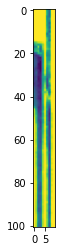

In [9]:
scelta = 120
scaler = StandardScaler() 
components = 40

if scelta == 70:
    pathBuoni = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni70/*.tif'
    pathBuoniVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni70Val/*.tif'

if scelta == 100:
    pathBuoni = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni100/*.tif'
    pathBuoniVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni100Val/*.tif'
if scelta == 120:
    pathBuoni = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni120/*.tif'
    pathBuoniVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni120Val/*.tif'

pathFS = '/Users/leonardoaggio/Desktop/Dataset/S606C/FalsiScarti/*.tif'
pathScarti = '/Users/leonardoaggio/Desktop/Dataset/S606C/Scarti/*.tif'

pathFSVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/FalsiScartiVal/*.tif'
pathScartiVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiVal/*.tif'

pezziXimmagine = 2
border = 50
Nclusters = 1

#
#


results = []
img_results = []
list_paths = []

list_paths += glob.glob(pathBuoni) 
results += [0] * len(glob.glob(pathBuoni)) * pezziXimmagine

#print(results)
i = 0
for img_path in list_paths:
    img = cv2.imread(img_path)
    temp = cutWorkSpace(img,border)
    cv2.imwrite('../ImgScarte/img'+str(i)+'.jpg', temp)
    temp2 = divideImage(temp,pezziXimmagine)
    img_results += temp2
    j = 0
    for im in temp2:
        #cv2.imwrite('ImgScarte/img'+str(i)+'pzs'+str(j)+'.jpg', im)
        j += 1
    i += 1
    
plt.imshow(img_results[0])
plt.show()

In [10]:
len(img_results[0][0])

10

In [11]:
train_images = np.array(img_results)
train_images = train_images/255.
imgsWithClass = [train_images,results]

In [12]:
24*36

864

In [13]:
df,feature_cols = createDF(imgsWithClass)

In [14]:
finalDf,pca = create_PCA(df,feature_cols,components)

Plot delle sole componenti di training

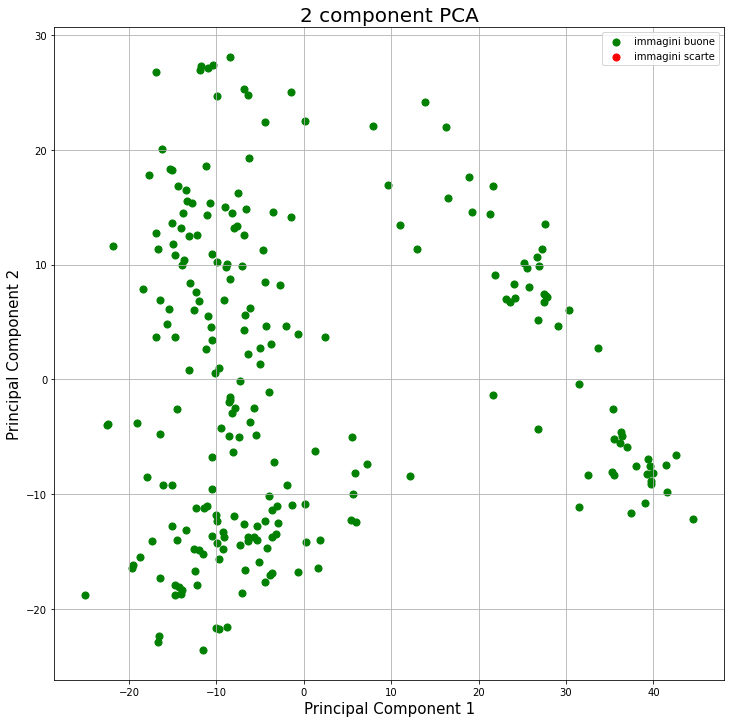

In [15]:
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['g', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['R'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
                #, finalDf.loc[indicesToKeep, 'R']
               , c = color
               , s = 50)
    
targets = ['immagini buone', 'immagini scarte']
ax.legend(targets)
ax.grid()
plt.savefig('PCAtrain.png')

In [16]:
pathFS = '/Users/leonardoaggio/Desktop/Dataset/S606C/FalsiScarti/*.tif'
pathScarti = '/Users/leonardoaggio/Desktop/Dataset/S606C/Scarti/*.tif'
st = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/*.tif'

pathFSVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/FalsiScartiVal/*.tif'
pathScartiVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiVal/*.tif'
tot = '/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/*.tif'


results = []
list_paths = []

pathToTest = st

list_paths += glob.glob(pathToTest) 
results += [1] * len(glob.glob(pathToTest)) * pezziXimmagine
i = 0
for k in range(len(list_paths)):
    img_results = []

    for img_path in list_paths[k:k+1]:
        img = cv2.imread(img_path)
        temp = cutWorkSpace(img,border)
        #cv2.imwrite('ImgScarte/img'+str(i)+'.jpg', temp)
        temp2 = divideImage(temp,pezziXimmagine)
        img_results += temp2

    train_images = np.array(img_results)
    train_images = train_images/255.
    imgsWithClass = [train_images,results]
    df2,feature_cols = createDF(imgsWithClass)
    finalDf2,cols_result = test_pca(df2,feature_cols,pca)
    #frames = [finalDf, finalDf2]
    #finalDf3 = pd.concat(frames)
    maxT, media,centerDist = maxAndMedian(finalDf2,cols_result)
    #print(k)
    #print(maxT)
    #print(media)
    #print(centerDist)
    if maxT > 50:
        i +=1
        #print(list_paths[k:k+1])
        
        
#print(str(i)+'/'+str(len(list_paths)))

In [17]:
pathFS = '/Users/leonardoaggio/Desktop/Dataset/S606C/FalsiScarti/*.tif'
pathScarti = '/Users/leonardoaggio/Desktop/Dataset/S606C/Scarti/*.tif'
st = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/*.tif'

pathFSVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/FalsiScartiVal/*.tif'
pathScartiVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiVal/*.tif'
tot = '/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/*.tif'


results = []
list_paths = []

pathToTest = tot

list_paths += glob.glob(pathToTest) 
results += [1] * len(glob.glob(pathToTest)) * pezziXimmagine
i = 0
img_results = []

for img_path in list_paths:
    img = cv2.imread(img_path)
    temp = cutWorkSpace(img,border)
    #cv2.imwrite('ImgScarte/img'+str(i)+'.jpg', temp)
    temp2 = divideImage(temp,pezziXimmagine)
    img_results += temp2

train_images = np.array(img_results)
train_images = train_images/255.
imgsWithClass = [train_images,results]
df2,feature_cols = createDF(imgsWithClass)
finalDf2,cols_result = test_pca(df2,feature_cols,pca)
frames = [finalDf, finalDf2]
finalDf3 = pd.concat(frames)
maxT, media,centerDist = maxAndMedian(finalDf2,cols_result)
print(maxT)
print(media)
print(centerDist)


93.49454930665442
33.66326069035366
12.542528865260623


In [18]:
maxT, media,centerDist = maxAndMedian(finalDf,cols_result)
print(maxT)
print(media)
print(centerDist)

65.28300113094379
29.83030952195758
4.6148728670591e-15


Plot di sole immagini prive di difetto

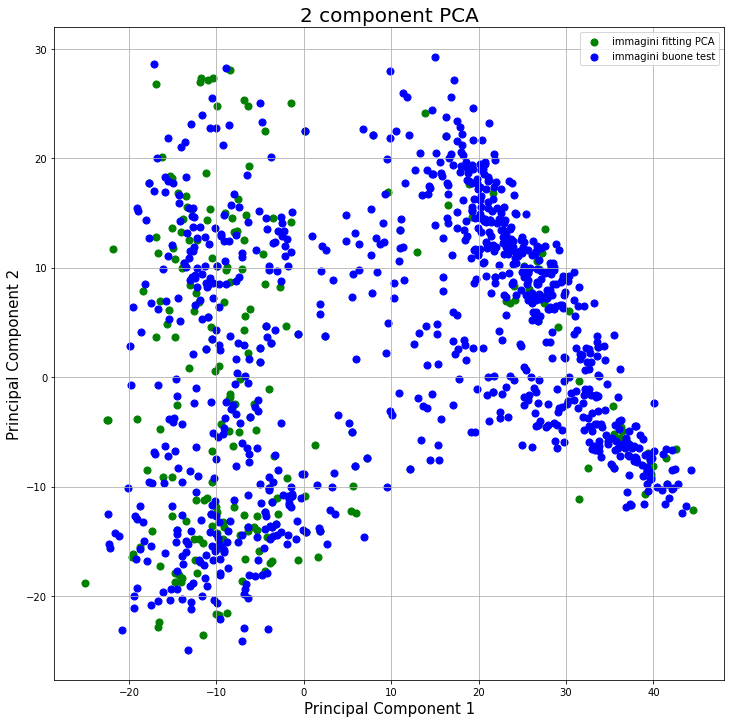

In [19]:
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf3['R'] == target
    ax.scatter(finalDf3.loc[indicesToKeep, 'PC1']
               , finalDf3.loc[indicesToKeep, 'PC2']
                #, finalDf.loc[indicesToKeep, 'R']
               , c = color
               , s = 50)
targets = ['immagini fitting PCA', 'immagini buone test']
ax.legend(targets)
ax.grid()
plt.savefig('PCAtest3.png')

In [20]:
pathFS = '/Users/leonardoaggio/Desktop/Dataset/S606C/FalsiScarti/*.tif'
pathScarti = '/Users/leonardoaggio/Desktop/Dataset/S606C/Scarti/*.tif'
st = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/*.tif'

pathFSVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/FalsiScartiVal/*.tif'
pathScartiVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiVal/*.tif'
tot = '/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/*.tif'


results = []
list_paths = []

pathToTest = st

list_paths = glob.glob(pathToTest) 
print(len(list_paths))
results = [2] * len(glob.glob(pathToTest)) * pezziXimmagine
img_results = []

for img_path in list_paths:
    img = cv2.imread(img_path)
    temp = cutWorkSpace(img,border)
    #cv2.imwrite('ImgScarte/img'+str(i)+'.jpg', temp)
    temp2 = divideImage(temp,pezziXimmagine)
    img_results += temp2

train_images = np.array(img_results)
train_images = train_images/255.
imgsWithClass = [train_images,results]
df4,feature_cols = createDF(imgsWithClass)
finalDf4,cols_result = test_pca(df4,feature_cols,pca)


9


Aggiunta degli scarti al precedente plot

In [21]:
frames = [finalDf3, finalDf4]
finalDf5 = pd.concat(frames)

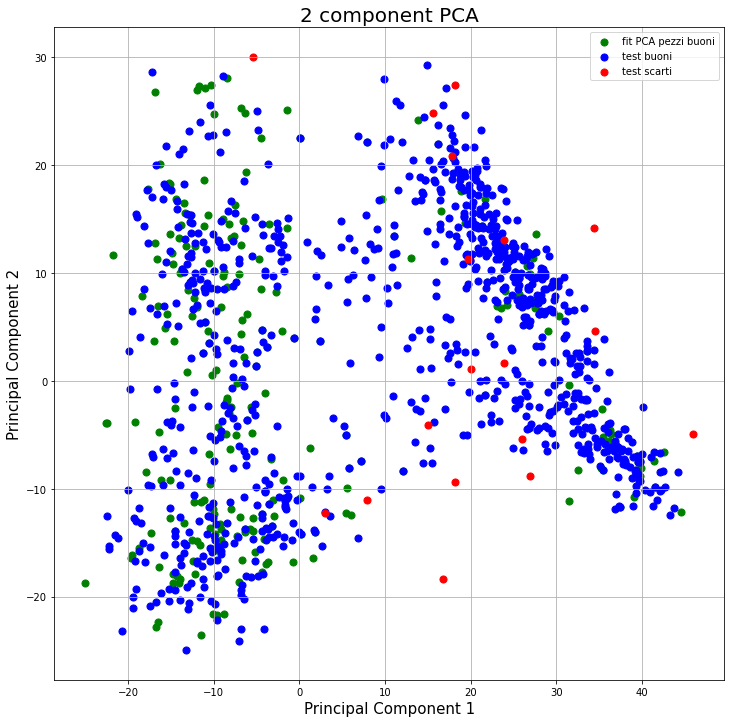

In [22]:
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1, 2]
colors = ['g', 'b', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf5['R'] == target
    ax.scatter(finalDf5.loc[indicesToKeep, 'PC1']
               , finalDf5.loc[indicesToKeep, 'PC2']
                #, finalDf.loc[indicesToKeep, 'R']
               , c = color
               , s = 50)
targets = ['fit PCA pezzi buoni','test buoni','test scarti']
ax.legend(targets)
ax.grid()
plt.savefig('PCAtest2.png')

#### Test identificazione degli scarti in maniera oggettiva. Test con utilizzo di log-likelihood

In [23]:
pathFS = '/Users/leonardoaggio/Desktop/Dataset/S606C/FalsiScarti/*.tif'
pathScarti = '/Users/leonardoaggio/Desktop/Dataset/S606C/Scarti/*.tif'
st = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/*.tif'

pathFSVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/FalsiScartiVal/*.tif'
pathScartiVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiVal/*.tif'
tot = '/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/*.tif'


results = []
list_paths = []

pathToTest = st

list_paths = glob.glob(pathToTest) 
print(len(list_paths))
results = [1] * len(glob.glob(pathToTest)) * pezziXimmagine
img_results = []
scoreST = []
for img_path in list_paths:
    img = cv2.imread(img_path)
    temp = cutWorkSpace(img,border)
    #cv2.imwrite('ImgScarte/img'+str(i)+'.jpg', temp)
    temp2 = divideImage(temp,pezziXimmagine)
    img_results = temp2
    train_images = np.array(img_results)
    train_images = train_images/255.
    imgsWithClass = [train_images,results]
    df4,feature_cols = createDF(imgsWithClass)
    scoreST.append(test_pca_score(df4,feature_cols,pca))


9


In [24]:
scoreST

[-2019.8929992166436,
 -2540.8155337092026,
 -564.7019992599544,
 -1045.1463994629946,
 -1560.2529260340907,
 -944.5988475111617,
 -1795.6835692288366,
 -1017.4563694108779,
 -701.9983690231771]

In [25]:
pathFS = '/Users/leonardoaggio/Desktop/Dataset/S606C/FalsiScarti/*.tif'
pathScarti = '/Users/leonardoaggio/Desktop/Dataset/S606C/Scarti/*.tif'
st = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/*.tif'

pathFSVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/FalsiScartiVal/*.tif'
pathScartiVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiVal/*.tif'
tot = '/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/*.tif'


results = []
list_paths = []

pathToTest = pathBuoni

list_paths = glob.glob(pathToTest) 
print(len(list_paths))
results = [2] * len(glob.glob(pathToTest)) * pezziXimmagine
img_results = []
score = []
for img_path in list_paths:
    img = cv2.imread(img_path)
    temp = cutWorkSpace(img,border)
    #cv2.imwrite('ImgScarte/img'+str(i)+'.jpg', temp)
    temp2 = divideImage(temp,pezziXimmagine)
    img_results = temp2
    train_images = np.array(img_results)
    train_images = train_images/255.
    imgsWithClass = [train_images,results]
    df4,feature_cols = createDF(imgsWithClass)
    score.append(test_pca_score(df4,feature_cols,pca))



119


In [26]:
pathFS = '/Users/leonardoaggio/Desktop/Dataset/S606C/FalsiScarti/*.tif'
pathScarti = '/Users/leonardoaggio/Desktop/Dataset/S606C/Scarti/*.tif'
st = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/*.tif'

pathFSVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/FalsiScartiVal/*.tif'
pathScartiVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiVal/*.tif'
tot = '/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/*.tif'


results = []
list_paths = []

pathToTest = pathBuoniVal

list_paths = glob.glob(pathToTest) 
print(len(list_paths))
results = [2] * len(glob.glob(pathToTest)) * pezziXimmagine
img_results = []
scoreV = []
for img_path in list_paths:
    img = cv2.imread(img_path)
    temp = cutWorkSpace(img,border)
    #cv2.imwrite('ImgScarte/img'+str(i)+'.jpg', temp)
    temp2 = divideImage(temp,pezziXimmagine)
    img_results = temp2
    train_images = np.array(img_results)
    train_images = train_images/255.
    imgsWithClass = [train_images,results]
    df4,feature_cols = createDF(imgsWithClass)
    scoreV.append(test_pca_score(df4,feature_cols,pca))




79


In [27]:
scoreST

[-2019.8929992166436,
 -2540.8155337092026,
 -564.7019992599544,
 -1045.1463994629946,
 -1560.2529260340907,
 -944.5988475111617,
 -1795.6835692288366,
 -1017.4563694108779,
 -701.9983690231771]

In [28]:
pathFS = '/Users/leonardoaggio/Desktop/Dataset/S606C/FalsiScarti/*.tif'
pathScarti = '/Users/leonardoaggio/Desktop/Dataset/S606C/Scarti/*.tif'
st = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/*.tif'

pathFSVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/FalsiScartiVal/*.tif'
pathScartiVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiVal/*.tif'
tot = '/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/*.tif'


results = []
list_paths = []

pathToTest = tot

list_paths = glob.glob(pathToTest) 
print(len(list_paths))
results = [2] * len(glob.glob(pathToTest)) * pezziXimmagine
scoreTOT = []
lenL = len(list_paths)
i = 0
for img_path in list_paths:
    img_results = []
    img = cv2.imread(img_path)
    temp = cutWorkSpace(img,border)
    #cv2.imwrite('ImgScarte/img'+str(i)+'.jpg', temp)
    temp2 = divideImage(temp,pezziXimmagine)
    img_results = temp2
    train_images = np.array(img_results)
    train_images = train_images/255.
    imgsWithClass = [train_images,results]
    df4,feature_cols = createDF(imgsWithClass)
    scoreTOT.append(test_pca_score(df4,feature_cols,pca))
    print(str(i+1) + '/' + str(lenL) )
    i += 1


436
1/436
2/436
3/436
4/436
5/436
6/436
7/436
8/436
9/436
10/436
11/436
12/436
13/436
14/436
15/436
16/436
17/436
18/436
19/436
20/436
21/436
22/436
23/436
24/436
25/436
26/436
27/436
28/436
29/436
30/436
31/436
32/436
33/436
34/436
35/436
36/436
37/436
38/436
39/436
40/436
41/436
42/436
43/436
44/436
45/436
46/436
47/436
48/436
49/436
50/436
51/436
52/436
53/436
54/436
55/436
56/436
57/436
58/436
59/436
60/436
61/436
62/436
63/436
64/436
65/436
66/436
67/436
68/436
69/436
70/436
71/436
72/436
73/436
74/436
75/436
76/436
77/436
78/436
79/436
80/436
81/436
82/436
83/436
84/436
85/436
86/436
87/436
88/436
89/436
90/436
91/436
92/436
93/436
94/436
95/436
96/436
97/436
98/436
99/436
100/436
101/436
102/436
103/436
104/436
105/436
106/436
107/436
108/436
109/436
110/436
111/436
112/436
113/436
114/436
115/436
116/436
117/436
118/436
119/436
120/436
121/436
122/436
123/436
124/436
125/436
126/436
127/436
128/436
129/436
130/436
131/436
132/436
133/436
134/436
135/436
136/436
137/436
138/436


In [29]:
i = 0 

s = scoreTOT

for el in s:
    if el < -400:
        i+= 1
        #print(i)
print(str(i)+'/'+str(len(s)))

244/436


In [30]:
scoreST

[-2019.8929992166436,
 -2540.8155337092026,
 -564.7019992599544,
 -1045.1463994629946,
 -1560.2529260340907,
 -944.5988475111617,
 -1795.6835692288366,
 -1017.4563694108779,
 -701.9983690231771]

In [31]:
import matplotlib.pyplot as plt

scoreSTX = scoreST
scoreSTY = []
for i in range(len(scoreST)):
    scoreSTY.append((i+1)*30)
    
scoreVX = scoreV
scoreVY = []
for i in range(len(scoreV)):
    scoreVY.append(i*3.55)
    
scoreTOTX = scoreTOT
scoreTOTY = []
for i in range(len(scoreTOT)):
    scoreTOTY.append(i)


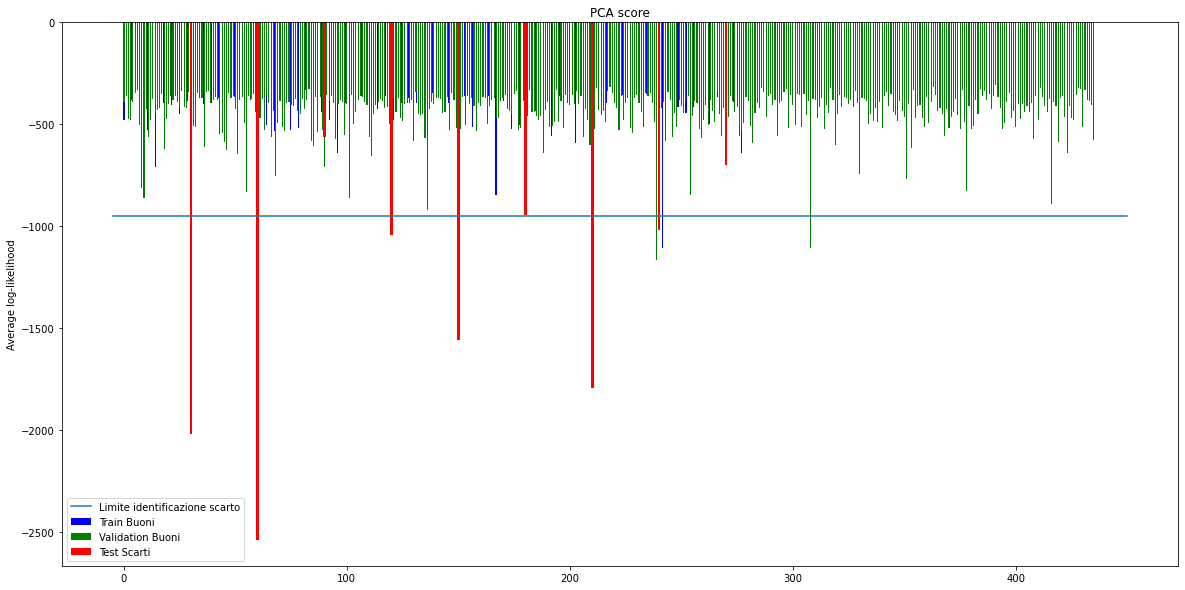

In [32]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
plt.bar(scoreVY,scoreVX,label='Train Buoni',color='b',width=.5)
plt.bar(scoreTOTY,scoreTOTX,label='Validation Buoni',color='g',width=.5)
plt.bar(scoreSTY,scoreSTX,label='Test Scarti',color='r',width=1.2)


lim = -950
x1 = [0, -600]
y1 = [0, -600]
plt.plot([-5,450],[lim,lim],label=('Limite identificazione scarto'))


#plt.bar([0.75,1.75,2.75,3.75,4.75],[50,30,20,50,60],

#label=”Female”, color=’g’,width=.5)

plt.legend()

#plt.xlabel('Days')

plt.ylabel('Average log-likelihood')

plt.title('PCA score')
plt.savefig('LogLik.png')
plt.show()


In [33]:

scoreSTX = scoreST
scoreSTY = []
for i in range(len(scoreST)):
    scoreSTY.append((i+1)*30)
    
scoreX = score
scoreY = []
for i in range(len(score)):
    scoreY.append(i*3.55)
    
scoreTOTX = scoreTOT
scoreTOTY = []
for i in range(len(scoreTOT)):
    scoreTOTY.append(i)



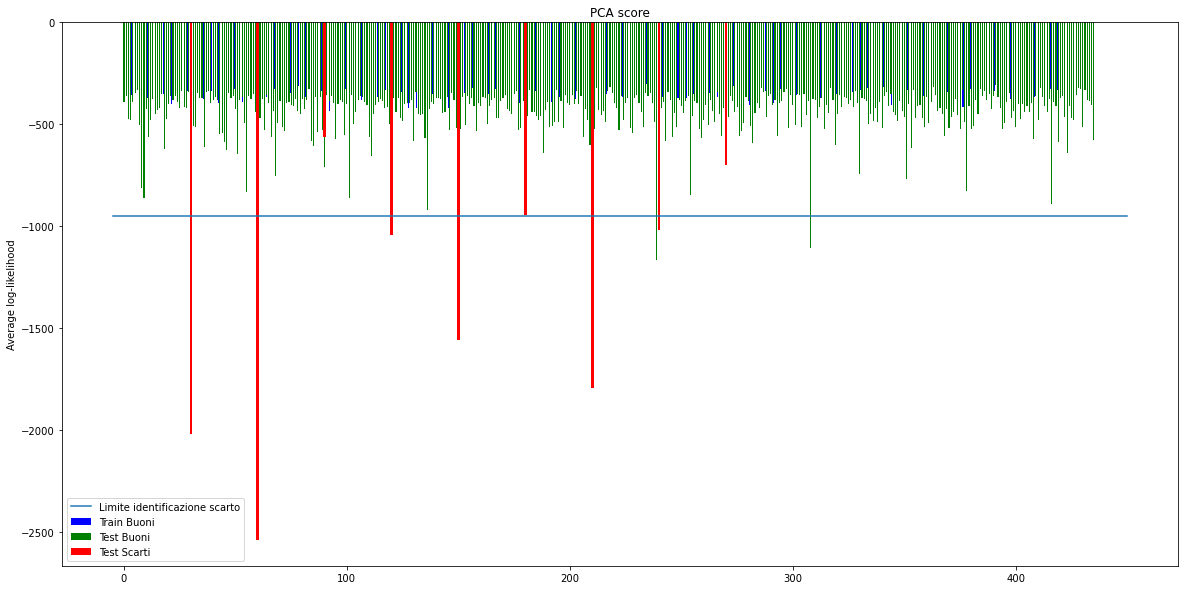

In [34]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
plt.bar(scoreY,scoreX,label='Train Buoni',color='b',width=.5)
plt.bar(scoreTOTY,scoreTOTX,label='Test Buoni',color='g',width=.5)
plt.bar(scoreSTY,scoreSTX,label='Test Scarti',color='r',width=1.2)


#lim = -390
x1 = [0, -600]
y1 = [0, -600]
plt.plot([-5,450],[lim,lim],label=('Limite identificazione scarto'))


#plt.bar([0.75,1.75,2.75,3.75,4.75],[50,30,20,50,60],

#label=”Female”, color=’g’,width=.5)

plt.legend()

#plt.xlabel('Days')

plt.ylabel('Average log-likelihood')
plt.title('PCA score')
plt.savefig('LogLik.png')
plt.show()



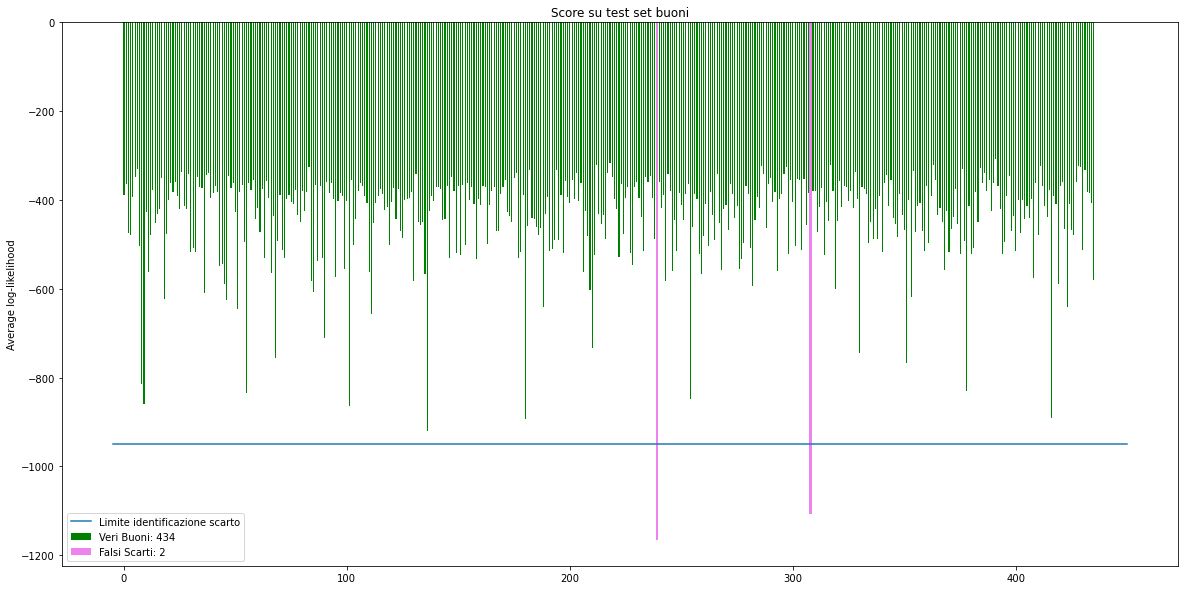

In [35]:
Xscarti = []
Yscarti = []
Xbuoni = []
Ybuoni = []

#discrimino buoni e scarti usando limite 11932
for i in range(len(scoreTOT)):
    if scoreTOTX[i] < lim:
        Xscarti.append(scoreTOTX[i])
        Yscarti.append(scoreTOTY[i])
    else:
        Xbuoni.append(scoreTOTX[i])
        Ybuoni.append(scoreTOTY[i])

plt.rcParams["figure.figsize"] = (20,10)
plt.bar(Ybuoni,Xbuoni,label=('Veri Buoni: '+ str(len(Xbuoni))),color='g',width=.5)
plt.bar(Yscarti,Xscarti,label=('Falsi Scarti: '+ str(len(Xscarti))),color='violet',width=1.2)


plt.plot([-5,450],[lim,lim],label=('Limite identificazione scarto'))

#plt.bar([0.75,1.75,2.75,3.75,4.75],[50,30,20,50,60],

#label=”Female”, color=’g’,width=.5)

plt.legend()

#plt.xlabel('Days')

plt.ylabel('Average log-likelihood')

plt.title('Score su test set buoni')
plt.savefig('LogLikTest.png')
plt.show()


In [36]:
errori = 0
for i in range(len(scoreTOT)):
    if scoreTOTX[i] < lim:
        errori += 1
print('Test error, falsi scarti: '+ str(errori))  
print(str(errori/len(scoreTOT)*100))

errori = 0
for i in range(len(scoreST)):
    if scoreSTX[i] >= lim:
        errori +=1
        
print('Test error, falsi buoni: '+ str(errori))
print(str(errori/len(scoreST)*100))



Test error, falsi scarti: 2
0.45871559633027525
Test error, falsi buoni: 3
33.33333333333333
